In [19]:
import tensorflow as tf

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import kneighbors_graph
from collections import Counter

In [20]:
root_path="../Projectors_publication/projector_Conso_CVAE_5couches-Month_Temp_Day-L1/"
sess= tf.Session()
saver = tf.train.import_meta_graph(root_path + "tf_data.ckpt.meta")
saver.restore(sess,root_path+"tf_data.ckpt")

INFO:tensorflow:Restoring parameters from ../Projectors_publication/projector_Conso_CVAE_5couches-Month_Temp_Day-L1/tf_data.ckpt


In [21]:
tf.get_variable('Variable_4', shape=(1500, 4))
embedding = sess.run('Variable_4:0')

In [22]:
embedding.shape

(1500, 4)

# Outlier detection using CFOF score
Intuitively, the CFOF score measures how many neighbors have to be taken into account in order for the object to be considered close by an appreciable fraction of the dataset objects. 

In [23]:
# hyperparameters settings 
n = 10

In [24]:
neighbors_graph = dict()

for i in range(1, n): 
    print(i, end='\r')
    neighbors_graph[i] = kneighbors_graph(X=embedding, n_neighbors=i, mode='connectivity')

In [25]:
def Nk(i,matrix_k):
    return sum(neighbors_graph[matrix_k].toarray()[:,i])-1
    
def CFOF_score(x_index, rho=0.001):
    k_list = []
    for k in range(1,n): 
        if Nk(x_index,k) >=(rho * n): 
            k_list.append(k/n)
    if len(k_list) == 0:
        raise ValueError('Error ')
    else : 
        return min(k_list)
    

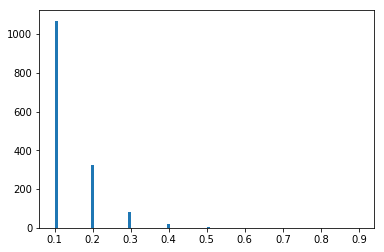

In [26]:
cfof_embedding = []

for i in range(len(embedding)):
    print(i, end='\r')
    cfof_embedding.append(CFOF_score(i, rho=0))
plt.figure()
plt.hist(cfof_embedding, bins = 100)
plt.show()

In [27]:
potential_outlier_with_threshold = np.where(np.array(cfof_embedding) > 0.5)[0]
potential_outlier_with_threshold

array([  5, 107])

5 = 1er janvier 2015
107 = 

In [21]:
def get_all_cfof_scores():
    cfof_thresholds = dict()
    for r in range(1,10):
        rho = r/10
        cfof_embedding = []

        for i in range(len(embedding)):
            print(i, end='\r')
            cfof_embedding.append(CFOF_score(i, rho))
        #plt.figure()
        #plt.hist(cfof_embedding, bins = 100)
        #plt.show()
        cfof_thresholds[rho] = cfof_embedding
    
    return cfof_thresholds

cfof_thresholds_dict = get_all_cfof_scores()

ValueError: Error 

In [3]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
# supress warnings for clean output
import warnings

warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

In [39]:
# TODO: add neural networks, LOCI, SOS
# TODO: and update output precision (=4)
# Define data file and read X and y

# 60% data for training and 40% for testing
embedding_norm = standardizer(embedding)
random_state = np.random.RandomState(42)
outliers_fraction = 20/1000
outliers_percentage = round(outliers_fraction * 100, ndigits=4)
# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=10), LOF(n_neighbors=20), LOF(n_neighbors=30),
                 LOF(n_neighbors=40), LOF(n_neighbors=50)]
classifiers = {'Angle-based Outlier Detector (ABOD)': ABOD(
    contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor': CBLOF(
        contamination=outliers_fraction, check_estimator=False,
        random_state=random_state),
    'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
                                      check_estimator=False,
                                      random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Local Outlier Factor (LOF)': LOF(
        contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction,
                                   random_state=random_state),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state)
}
classifiers_indices = {
    'Angle-based Outlier Detector (ABOD)': 0,
    'Cluster-based Local Outlier Factor': 1,
    'Feature Bagging': 2,
    'Histogram-base Outlier Detection (HBOS)': 3,
    'Isolation Forest': 4,
    'K Nearest Neighbors (KNN)': 5,
    'Local Outlier Factor (LOF)': 6,
    'Minimum Covariance Determinant (MCD)': 7,
    'One-class SVM (OCSVM)': 8,
    'Principal Component Analysis (PCA)': 9,
    'Locally Selective Combination (LSCP)': 10}

n_ite = 50
n_classifiers = 11

df_columns = ['Data', '#Samples', '# Dimensions', 'Outlier Perc',
              'ABOD', 'CBLOF', 'FB', 'HBOS', 'IForest', 'KNN', 'LOF',
              'MCD', 'OCSVM', 'PCA', 'LSCP']
time_df = pd.DataFrame(columns=df_columns)



res_dict = {}
for clf_name, clf in classifiers.items():
    res_dict[clf_name]=[]

time_mat = np.zeros([n_ite, n_classifiers])
res_mat = np.zeros([n_ite, n_classifiers])


for i in range(n_ite):
    print("\n... Processing", '...', 'Iteration', i + 1)
    random_state = np.random.RandomState(i)
    outliers_fraction = 20/1000
    outliers_percentage = round(outliers_fraction * 100, ndigits=4)

    classifiers = {'Angle-based Outlier Detector (ABOD)': ABOD(
        contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor': CBLOF(
            contamination=outliers_fraction, check_estimator=False,
            random_state=random_state),
        'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
                                          check_estimator=False,
                                          random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(
            contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,
                                    random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Local Outlier Factor (LOF)': LOF(
            contamination=outliers_fraction),
        'Minimum Covariance Determinant (MCD)': MCD(
            contamination=outliers_fraction, random_state=random_state),
        'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction,
                                       random_state=random_state),
        'Principal Component Analysis (PCA)': PCA(
            contamination=outliers_fraction, random_state=random_state),

    }
    for clf_name, clf in classifiers.items():
        t0 = time()
        res =np.where(clf.fit_predict(embedding_norm) != 0)[0]
        t1 = time()
        duration = round(t1 - t0, ndigits=4)

        print('ratio for {} {} in {}'.format(clf_name,len(res),duration))

        time_mat[i, classifiers_indices[clf_name]] = duration
        res_dict[clf_name]+=list(res)



... Processing ... Iteration 1
ratio for Angle-based Outlier Detector (ABOD) 15 in 0.1877
ratio for Cluster-based Local Outlier Factor 15 in 0.1198
ratio for Feature Bagging 15 in 0.0864
ratio for Histogram-base Outlier Detection (HBOS) 15 in 0.0015
ratio for Isolation Forest 15 in 0.1733
ratio for K Nearest Neighbors (KNN) 15 in 0.0059
ratio for Local Outlier Factor (LOF) 15 in 0.0097
ratio for Minimum Covariance Determinant (MCD) 15 in 0.6384
ratio for One-class SVM (OCSVM) 15 in 0.0722
ratio for Principal Component Analysis (PCA) 15 in 0.0015

... Processing ... Iteration 2
ratio for Angle-based Outlier Detector (ABOD) 15 in 0.1971
ratio for Cluster-based Local Outlier Factor 15 in 0.1084
ratio for Feature Bagging 15 in 0.1001
ratio for Histogram-base Outlier Detection (HBOS) 15 in 0.0018
ratio for Isolation Forest 15 in 0.1903
ratio for K Nearest Neighbors (KNN) 15 in 0.0061
ratio for Local Outlier Factor (LOF) 15 in 0.0115
ratio for Minimum Covariance Determinant (MCD) 15 in 0.66

ratio for Angle-based Outlier Detector (ABOD) 15 in 0.1933
ratio for Cluster-based Local Outlier Factor 15 in 0.1105
ratio for Feature Bagging 15 in 0.0893
ratio for Histogram-base Outlier Detection (HBOS) 15 in 0.0021
ratio for Isolation Forest 15 in 0.1856
ratio for K Nearest Neighbors (KNN) 15 in 0.0059
ratio for Local Outlier Factor (LOF) 15 in 0.0109
ratio for Minimum Covariance Determinant (MCD) 15 in 0.7223
ratio for One-class SVM (OCSVM) 15 in 0.0764
ratio for Principal Component Analysis (PCA) 15 in 0.0015

... Processing ... Iteration 17
ratio for Angle-based Outlier Detector (ABOD) 15 in 0.2039
ratio for Cluster-based Local Outlier Factor 15 in 0.1146
ratio for Feature Bagging 15 in 0.0903
ratio for Histogram-base Outlier Detection (HBOS) 15 in 0.0016
ratio for Isolation Forest 15 in 0.1633
ratio for K Nearest Neighbors (KNN) 15 in 0.0056
ratio for Local Outlier Factor (LOF) 15 in 0.0095
ratio for Minimum Covariance Determinant (MCD) 15 in 0.6626
ratio for One-class SVM (OCS

ratio for Angle-based Outlier Detector (ABOD) 15 in 0.2235
ratio for Cluster-based Local Outlier Factor 15 in 0.1279
ratio for Feature Bagging 15 in 0.091
ratio for Histogram-base Outlier Detection (HBOS) 15 in 0.0019
ratio for Isolation Forest 15 in 0.1791
ratio for K Nearest Neighbors (KNN) 15 in 0.0056
ratio for Local Outlier Factor (LOF) 15 in 0.0101
ratio for Minimum Covariance Determinant (MCD) 15 in 0.6643
ratio for One-class SVM (OCSVM) 15 in 0.0715
ratio for Principal Component Analysis (PCA) 15 in 0.0014

... Processing ... Iteration 32
ratio for Angle-based Outlier Detector (ABOD) 15 in 0.1858
ratio for Cluster-based Local Outlier Factor 15 in 0.1007
ratio for Feature Bagging 15 in 0.0787
ratio for Histogram-base Outlier Detection (HBOS) 15 in 0.0015
ratio for Isolation Forest 15 in 0.1762
ratio for K Nearest Neighbors (KNN) 15 in 0.0058
ratio for Local Outlier Factor (LOF) 15 in 0.0096
ratio for Minimum Covariance Determinant (MCD) 15 in 0.6798
ratio for One-class SVM (OCSV

ratio for Angle-based Outlier Detector (ABOD) 15 in 0.1918
ratio for Cluster-based Local Outlier Factor 15 in 0.1442
ratio for Feature Bagging 15 in 0.0848
ratio for Histogram-base Outlier Detection (HBOS) 15 in 0.0019
ratio for Isolation Forest 15 in 0.1713
ratio for K Nearest Neighbors (KNN) 15 in 0.0054
ratio for Local Outlier Factor (LOF) 15 in 0.0095
ratio for Minimum Covariance Determinant (MCD) 15 in 0.6681
ratio for One-class SVM (OCSVM) 15 in 0.0694
ratio for Principal Component Analysis (PCA) 15 in 0.0016

... Processing ... Iteration 47
ratio for Angle-based Outlier Detector (ABOD) 15 in 0.2038
ratio for Cluster-based Local Outlier Factor 15 in 0.109
ratio for Feature Bagging 15 in 0.0784
ratio for Histogram-base Outlier Detection (HBOS) 15 in 0.002
ratio for Isolation Forest 15 in 0.1696
ratio for K Nearest Neighbors (KNN) 15 in 0.0056
ratio for Local Outlier Factor (LOF) 15 in 0.0096
ratio for Minimum Covariance Determinant (MCD) 15 in 0.5941
ratio for One-class SVM (OCSVM

In [40]:
outliers_freq_dict=dict()
for clf_name, clf in classifiers.items():
    outliers_freq_dict[clf_name]=[]

for key, value in res_dict.items():
    outliers_freq_dict[key] = dict(Counter(sorted(value)))

In [41]:
outliers_dict=dict()
for clf_name, clf in classifiers.items():
    outliers_dict[clf_name]=[]

for key, value in outliers_freq_dict.items():
    outliers_dict[key] = [k for k,v in value.items() if v >= 40]

In [42]:
outliers_list = []
for key, value in outliers_dict.items():
    outliers_list +=value

In [43]:
real_outliers =dict(Counter(sorted(outliers_list)))

In [33]:
np.savez('outliers_temp_month_day', outliers=real_outliers)

In [11]:
real_outliers = np.load('outliers_temp_month_day.npz')['outliers']

In [18]:
real_outliers

array({3: 5, 4: 7, 5: 9, 66: 5, 73: 9, 94: 7, 107: 9, 124: 3, 125: 1, 132: 3, 133: 3, 143: 6, 155: 4, 191: 1, 198: 1, 219: 1, 226: 1, 230: 3, 287: 4, 292: 2, 308: 1, 313: 1, 318: 2, 346: 3, 361: 1, 362: 7, 363: 5, 369: 7, 436: 2, 463: 3, 477: 1, 479: 7, 489: 3, 509: 4, 527: 2, 528: 6, 563: 2, 583: 1, 595: 1, 596: 1, 647: 1, 719: 2, 727: 5, 728: 6, 734: 7, 742: 1, 775: 1, 800: 3, 829: 4, 854: 3, 867: 4, 868: 8, 877: 3, 878: 2, 927: 1, 947: 1, 954: 1, 960: 2, 1048: 1, 1092: 6, 1095: 3, 1097: 5, 1098: 1, 1099: 3, 1186: 3, 1192: 1, 1222: 1, 1224: 4, 1235: 5, 1249: 1, 1294: 1, 1299: 1, 1300: 1, 1318: 1, 1325: 1, 1326: 3, 1375: 1, 1382: 1, 1396: 2, 1403: 3, 1404: 1, 1458: 4, 1461: 2, 1465: 1, 1485: 8, 1486: 1, 1491: 8, 1492: 9},
      dtype=object)

In [53]:
[k for k,v in real_outliers.items()]


[3,
 4,
 5,
 66,
 73,
 94,
 107,
 124,
 125,
 132,
 133,
 143,
 155,
 191,
 198,
 219,
 226,
 230,
 287,
 292,
 308,
 313,
 318,
 346,
 361,
 362,
 363,
 369,
 436,
 463,
 477,
 479,
 489,
 509,
 527,
 528,
 563,
 583,
 595,
 596,
 647,
 719,
 727,
 728,
 734,
 742,
 775,
 800,
 829,
 854,
 867,
 868,
 877,
 878,
 927,
 947,
 954,
 960,
 1048,
 1092,
 1095,
 1097,
 1098,
 1099,
 1186,
 1192,
 1222,
 1224,
 1235,
 1249,
 1294,
 1299,
 1300,
 1318,
 1325,
 1326,
 1375,
 1382,
 1396,
 1403,
 1404,
 1458,
 1461,
 1465,
 1485,
 1486,
 1491,
 1492]

In [52]:
list_wd = [5,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 39,
 53,
 57,
 58,
 65,
 66,
 74,
 77,
 107,
 130,
 170,
 223,
 224,
 227,
 228,
 229,
 231,
 232,
 240,
 304,
 327,
 329,
 435,
 437,
 455,
 493,
 497,
 518,
 584,
 585,
 586,
 587,
 588,
 591,
 592,
 593,
 594,
 598,
 599,
 601,
 603,
 604,
 668,
 675,
 703,
 705,
 730,
 769,
 770,
 771,
 775,
 797,
 798,
 799,
 815,
 831,
 832,
 868,
 928,
 929,
 945,
 950,
 951,
 952,
 955,
 956,
 957,
 958,
 959,
 960,
 962,
 963,
 964,
 966,
 967,
 968,
 1008,
 1046,
 1058,
 1116,
 1208,
 1223,
 1225,
 1245,
 1260,
 1294,
 1295,
 1319,
 1320,
 1321,
 1322,
 1323,
 1327,
 1336,
 1464,
 1467,
 1477,
 1482,
 1483,
 1484,
 1485,
 1486,
 1488,
 1489,
 1490]

In [49]:
real_outliers

{3: 5,
 4: 7,
 5: 9,
 66: 5,
 73: 9,
 94: 7,
 107: 9,
 124: 3,
 125: 1,
 132: 3,
 133: 3,
 143: 6,
 155: 4,
 191: 1,
 198: 1,
 219: 1,
 226: 1,
 230: 3,
 287: 4,
 292: 2,
 308: 1,
 313: 1,
 318: 2,
 346: 3,
 361: 1,
 362: 7,
 363: 5,
 369: 7,
 436: 2,
 463: 3,
 477: 1,
 479: 7,
 489: 3,
 509: 4,
 527: 2,
 528: 6,
 563: 2,
 583: 1,
 595: 1,
 596: 1,
 647: 1,
 719: 2,
 727: 5,
 728: 6,
 734: 7,
 742: 1,
 775: 1,
 800: 3,
 829: 4,
 854: 3,
 867: 4,
 868: 8,
 877: 3,
 878: 2,
 927: 1,
 947: 1,
 954: 1,
 960: 2,
 1048: 1,
 1092: 6,
 1095: 3,
 1097: 5,
 1098: 1,
 1099: 3,
 1186: 3,
 1192: 1,
 1222: 1,
 1224: 4,
 1235: 5,
 1249: 1,
 1294: 1,
 1299: 1,
 1300: 1,
 1318: 1,
 1325: 1,
 1326: 3,
 1375: 1,
 1382: 1,
 1396: 2,
 1403: 3,
 1404: 1,
 1458: 4,
 1461: 2,
 1465: 1,
 1485: 8,
 1486: 1,
 1491: 8,
 1492: 9}

In [ ]:
^(4|5|73|94|107|143|362|369|479|528|728|734|868|1092|1485|1491|1492)$